In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("loan_default.csv")

In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
     data, test_size=0.30, random_state=42)

In [52]:
train.shape

(56000, 89)

In [5]:
var = pd.DataFrame(train.dtypes)
var.head(10)

,0
Unnamed: 0,int64
Unnamed: 0.1,int64
id,int64
loan_default,int64
AP001,int64
AP002,int64
AP003,int64
AP004,int64
AP005,object
AP006,object


In [6]:
var = pd.DataFrame(train.dtypes).reset_index()
var.head()

,index,0
0,Unnamed: 0,int64
1,Unnamed: 0.1,int64
2,id,int64
3,loan_default,int64
4,AP001,int64


In [7]:
var.columns = ['varname','dtype'] 
var.head(10)

,varname,dtype
0,Unnamed: 0,int64
1,Unnamed: 0.1,int64
2,id,int64
3,loan_default,int64
4,AP001,int64
5,AP002,int64
6,AP003,int64
7,AP004,int64
8,AP005,object
9,AP006,object


In [8]:
var['source'] = var['varname'].str[:2]
var.head()

,varname,dtype,source
0,Unnamed: 0,int64,Un
1,Unnamed: 0.1,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP


In [9]:
var['source'].value_counts()

CD    36
TD    24
AP     9
CR     8
PA     6
MB     2
Un     2
id     1
lo     1
Name: source, dtype: int64

In [10]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [11]:
train['loan_default'].value_counts(dropna=False)

0    45180
1    10820
Name: loan_default, dtype: int64

In [12]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,7 days 9 hours 29 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.4
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_jjzhang_rqihyg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,988 Mb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [13]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [14]:
target='loan_default'

In [15]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [16]:
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 

In [17]:
gbm_v1 = H2OGradientBoostingEstimator(
        model_id = 'gbm_v1',
        seed=1234)
gbm_v1.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


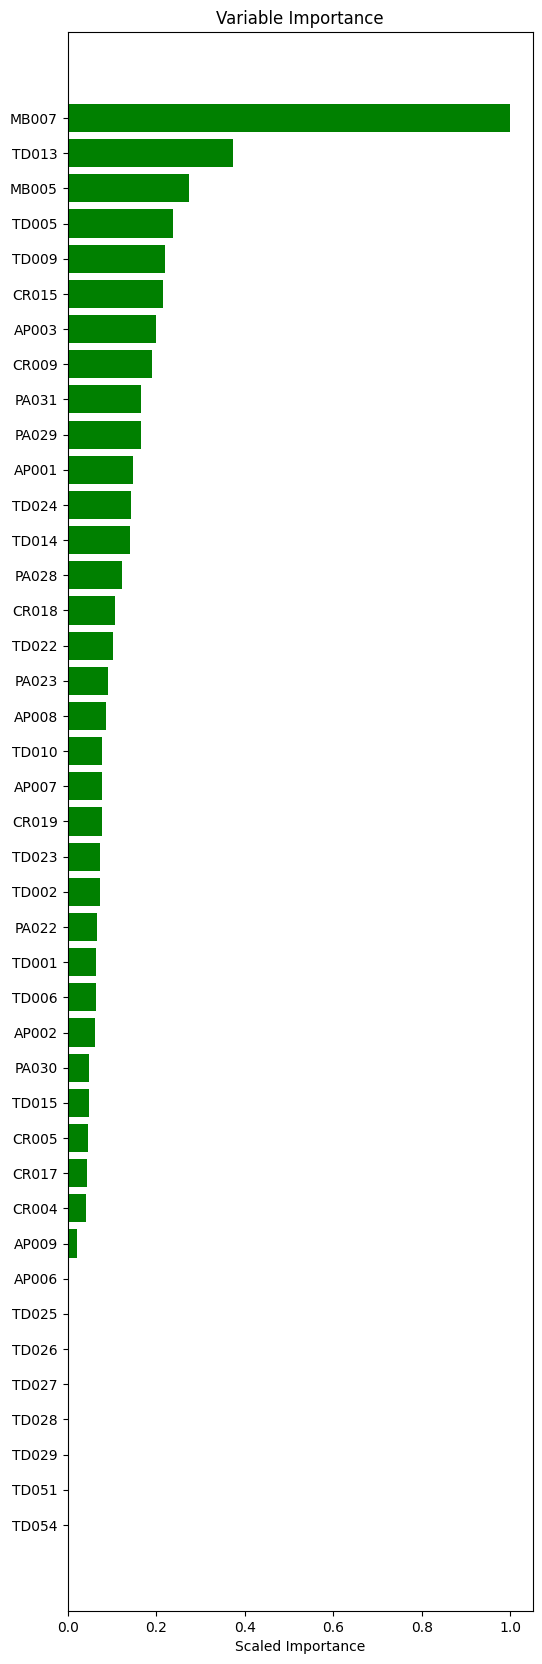

In [19]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()
    
VarImp(gbm_v1)

In [22]:
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(gbm_v1)

gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,80,160,240,80,160,0.16,0.08,49.0,1.63,8.0,33.33
1,240,62,178,480,142,338,0.29,0.18,98.0,1.45,11.0,29.58
2,240,68,172,720,210,510,0.43,0.27,147.0,1.43,16.0,29.17
3,240,62,178,960,272,688,0.56,0.36,196.0,1.39,20.0,28.33
4,240,40,200,1200,312,888,0.64,0.46,245.0,1.27,18.0,26.00
5,240,48,192,1440,360,1080,0.73,0.57,294.0,1.22,16.0,25.00
6,240,45,195,1680,405,1275,0.83,0.67,343.0,1.18,16.0,24.11
7,240,30,210,1920,435,1485,0.89,0.78,392.0,1.11,11.0,22.66
8,240,33,207,2160,468,1692,0.96,0.89,441.0,1.06,7.0,21.67


In [23]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



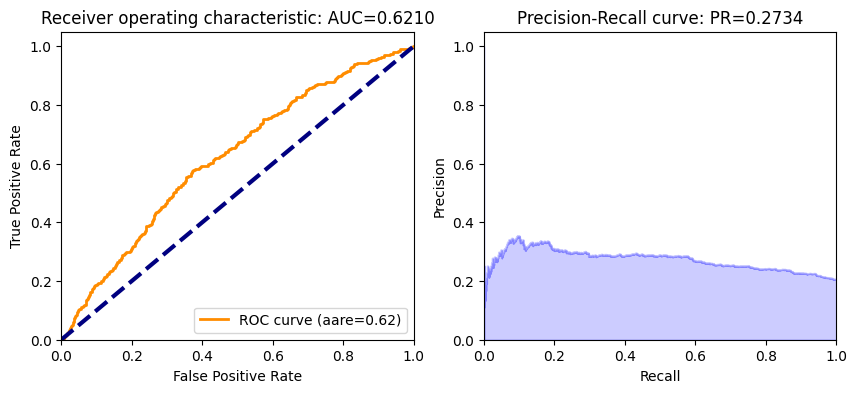

In [24]:
ROC_AUC(gbm_v1,test_hex,'loan_default')

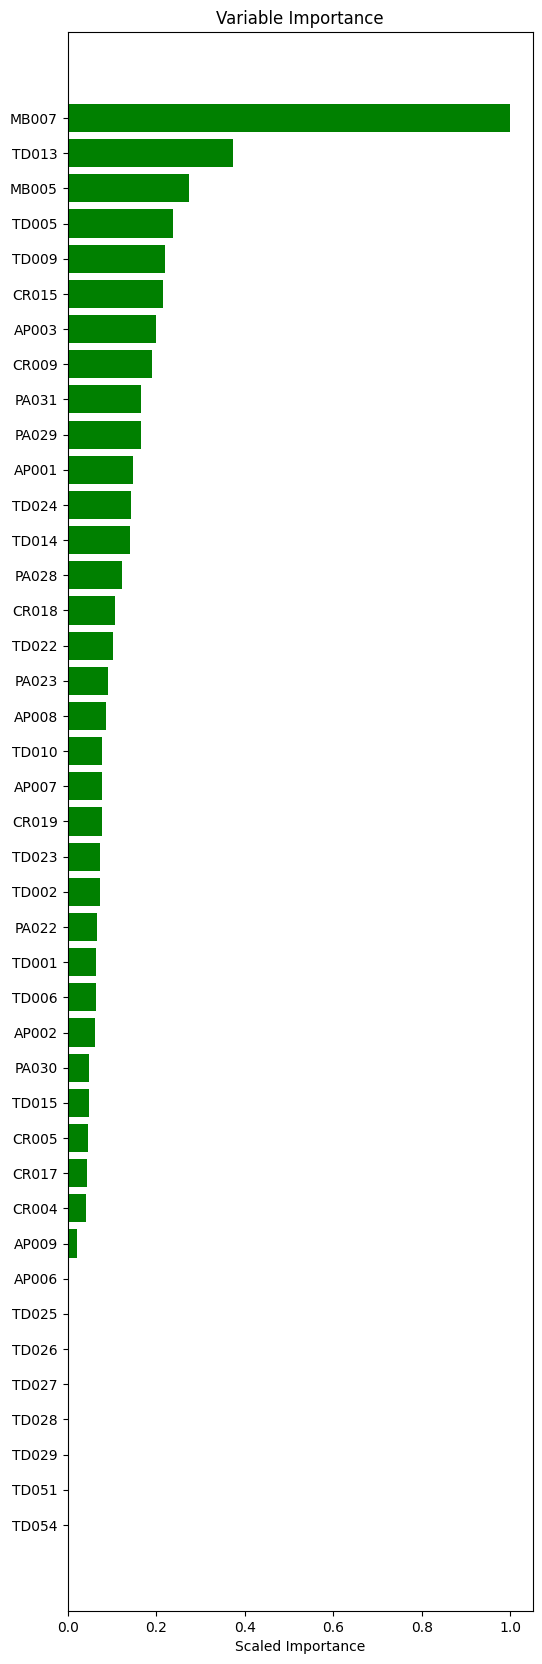

In [29]:
VarImp(gbm_v1)

# GBM on actual dataset

In [58]:
train_act = h2o.H2OFrame(train)
test_act = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [60]:
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 

In [61]:
gbm_v2 = H2OGradientBoostingEstimator(
        model_id = 'gbm_v2',
        seed=1234)
gbm_v2.train(predictors,target,training_frame=train_act)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [62]:
createGains(gbm_v2)

gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,79,161,240,79,161,0.16,0.08,49.0,1.61,8.0,32.92
1,240,87,153,480,166,314,0.34,0.16,98.0,1.69,18.0,34.58
2,240,64,176,720,230,490,0.47,0.26,147.0,1.56,21.0,31.94
3,240,54,186,960,284,676,0.58,0.35,196.0,1.45,23.0,29.58
4,240,39,201,1200,323,877,0.66,0.46,245.0,1.32,20.0,26.92
5,240,58,182,1440,381,1059,0.78,0.55,294.0,1.30,23.0,26.46
6,240,35,205,1680,416,1264,0.85,0.66,343.0,1.21,19.0,24.76
7,240,33,207,1920,449,1471,0.92,0.77,392.0,1.15,15.0,23.39
8,240,20,220,2160,469,1691,0.96,0.89,441.0,1.06,7.0,21.71


gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



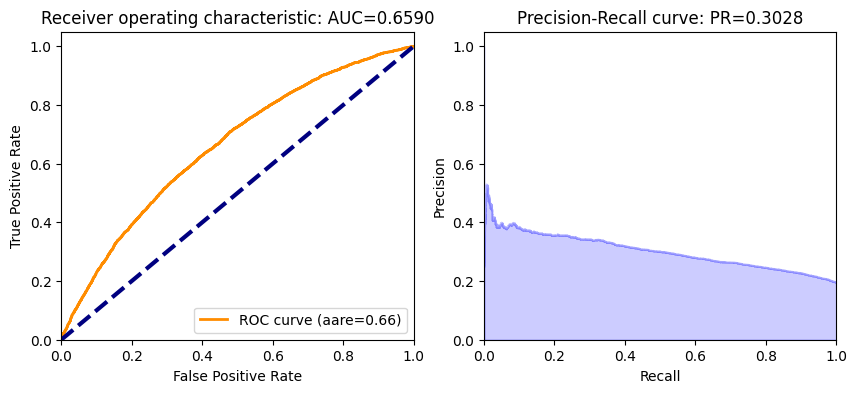

In [63]:
ROC_AUC(gbm_v2,test_act,'loan_default')

# Feature reduction

In [45]:
predictors = ['MB007','TD013','MB005','TD005','TD009','CR015','AP003','CR009','PA031','PA029','AP001','TD024','TD014']

I found that with the TOP 13 VARIABLES, the cum lift level, AUC, precision level remain relatively similar.

In [46]:
gbm_v3 = H2OGradientBoostingEstimator(
        model_id = 'gbm_v2',
        seed=1234)
gbm_v3.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [47]:
createGains(gbm_v3)

gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,80,160,240,80,160,0.16,0.08,49.0,1.63,8.0,33.33
1,240,65,175,480,145,335,0.30,0.18,98.0,1.48,12.0,30.21
2,240,69,171,720,214,506,0.44,0.26,147.0,1.46,18.0,29.72
3,240,44,196,960,258,702,0.53,0.37,196.0,1.32,16.0,26.88
4,240,54,186,1200,312,888,0.64,0.46,245.0,1.27,18.0,26.00
5,240,52,188,1440,364,1076,0.74,0.56,294.0,1.24,18.0,25.28
6,240,36,204,1680,400,1280,0.82,0.67,343.0,1.17,15.0,23.81
7,240,36,204,1920,436,1484,0.89,0.78,392.0,1.11,11.0,22.71
8,240,29,211,2160,465,1695,0.95,0.89,441.0,1.05,6.0,21.53


gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



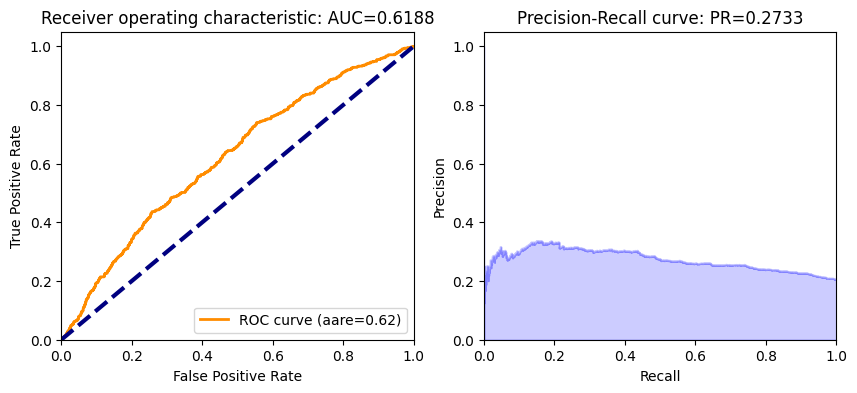

In [48]:
ROC_AUC(gbm_v3,test_hex,'loan_default')

# GBM on actual dataset after feature reduction

In [64]:
predictors = ['MB007','TD013','MB005','TD005','TD009','CR015','AP003','CR009','PA031','PA029','AP001','TD024','TD014']

In [65]:
gbm_v4 = H2OGradientBoostingEstimator(
        model_id = 'gbm_v4',
        seed=1234)
gbm_v4.train(predictors,target,training_frame=train_act)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [66]:
createGains(gbm_v4)

gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,88,152,240,88,152,0.18,0.08,49.0,1.80,10.0,36.67
1,240,74,166,480,162,318,0.33,0.17,98.0,1.65,16.0,33.75
2,240,56,184,720,218,502,0.44,0.26,147.0,1.48,18.0,30.28
3,240,48,192,960,266,694,0.54,0.36,196.0,1.36,18.0,27.71
4,240,61,179,1200,327,873,0.67,0.46,245.0,1.33,21.0,27.25
5,240,48,192,1440,375,1065,0.77,0.56,294.0,1.28,21.0,26.04
6,240,33,207,1680,408,1272,0.83,0.67,343.0,1.19,16.0,24.29
7,240,36,204,1920,444,1476,0.91,0.77,392.0,1.13,14.0,23.12
8,240,24,216,2160,468,1692,0.96,0.89,441.0,1.06,7.0,21.67


gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



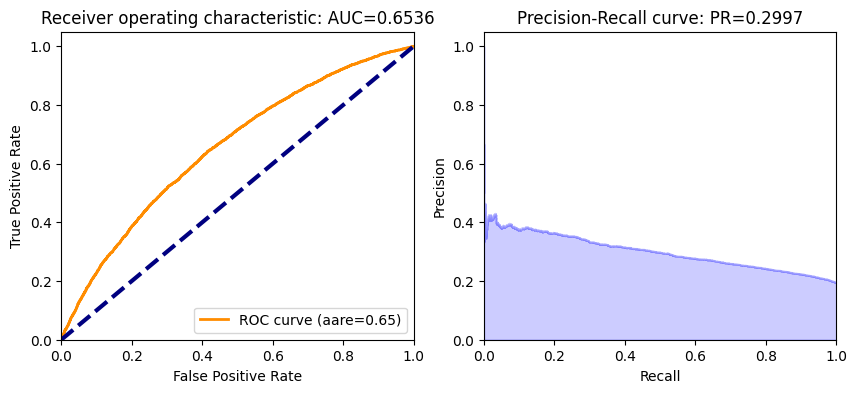

In [145]:
ROC_AUC(gbm_v4,test_act,'loan_default')

When evaluating the performance in the of all-variable model and reduced feature model, I found that the lift level experience a large increase, while the AUC and PR took a slight hit. It is a tradeoffs I think most people are willing to make considering the less feature would be reduction in the complexitity of the model.

# Deep learning

In [ ]:
ROC_AUC(gbm_v2,test_act,'loan_default')

In [69]:
from h2o.estimators import H2ODeepLearningEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,7 days 10 hours 23 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.4
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_jjzhang_rqihyg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,955 Mb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [138]:

train_act = h2o.H2OFrame(train)
test_act = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


Develop deep learning with reduced features and default stopping metric(auto).

In [132]:
# Build and train the model:
dl = H2ODeepLearningEstimator(
                               hidden=[13,7,2,7,13],
                               epochs=1000,
                               train_samples_per_iteration=-1,
                               reproducible=True,
                               seed = 1234)


dl.train(predictors,target,training_frame=train_act)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [133]:
createGains(dl)

deeplearning prediction progress: |███████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,97,143,240,97,143,0.20,0.07,49.0,1.98,13.0,40.42
1,240,72,168,480,169,311,0.34,0.16,98.0,1.72,18.0,35.21
2,240,57,183,720,226,494,0.46,0.26,147.0,1.54,20.0,31.39
3,240,61,179,960,287,673,0.59,0.35,196.0,1.46,24.0,29.90
4,240,45,195,1200,332,868,0.68,0.45,245.0,1.36,23.0,27.67
5,240,42,198,1440,374,1066,0.76,0.56,294.0,1.27,20.0,25.97
6,240,42,198,1680,416,1264,0.85,0.66,343.0,1.21,19.0,24.76
7,240,26,214,1920,442,1478,0.90,0.77,392.0,1.13,13.0,23.02
8,240,22,218,2160,464,1696,0.95,0.89,441.0,1.05,6.0,21.48


deeplearning prediction progress: |███████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



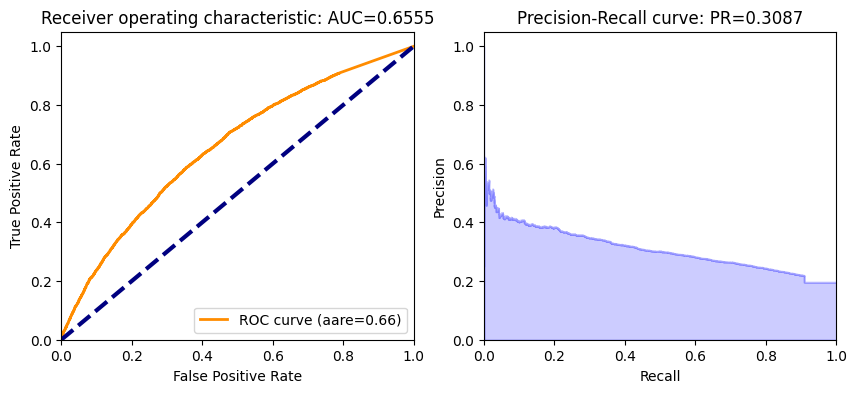

In [134]:
ROC_AUC(dl,test_act,'loan_default')

### Deep learning with lift_top_group metric

In [142]:

dl2 = H2ODeepLearningEstimator(
                               hidden=[13,7,2,7,13],
                               epochs=1000,
                               train_samples_per_iteration=-1,
                               reproducible=True,
                               seed = 1234,
                               stopping_metric = 'lift_top_group')

dl2.train(predictors,target,training_frame=train_act)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


Adding stopping metric = lift_top_group

In [143]:
createGains(dl2)

deeplearning prediction progress: |███████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,85,155,240,85,155,0.17,0.08,49.0,1.73,9.0,35.42
1,240,67,173,480,152,328,0.31,0.17,98.0,1.55,14.0,31.67
2,240,81,159,720,233,487,0.48,0.25,147.0,1.59,23.0,32.36
3,240,47,193,960,280,680,0.57,0.36,196.0,1.43,21.0,29.17
4,240,47,193,1200,327,873,0.67,0.46,245.0,1.33,21.0,27.25
5,240,44,196,1440,371,1069,0.76,0.56,294.0,1.26,20.0,25.76
6,240,36,204,1680,407,1273,0.83,0.67,343.0,1.19,16.0,24.23
7,240,28,212,1920,435,1485,0.89,0.78,392.0,1.11,11.0,22.66
8,240,24,216,2160,459,1701,0.94,0.89,441.0,1.04,5.0,21.25


deeplearning prediction progress: |███████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



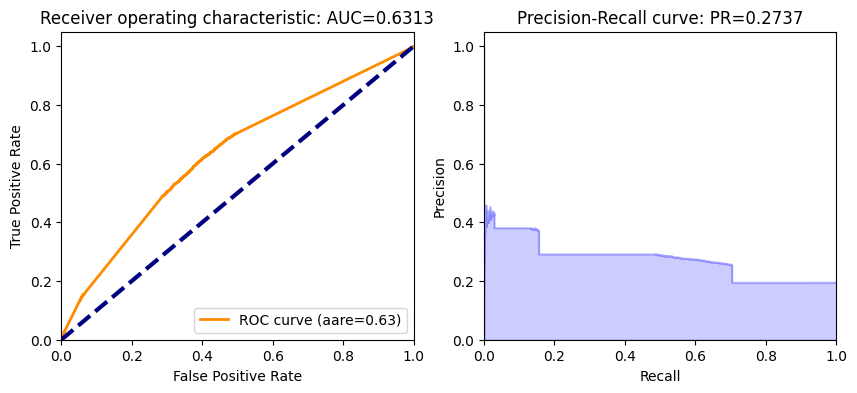

In [144]:
ROC_AUC(dl2,test_act,'loan_default')